# Capstone Project - Benchmark Model 

>- **Objective**: Whether one is overweight or not, is actually really straightforward to measure. Instead of predicting overweight, this project is trying to predict whether one will increase their weight or not within a year, given the lifestyle they currently have.
>- **y**: It is a supervised learning classification problem. Target is defined as 1 if weight increase is larger than 5 pounds over a year. 
>- **X**:Inputs are personal demographic, dietary and laboratory data
>- **This notebook will only cover data exploration and Benchmark model**

## 1. Set up 
>- Jupyter notebook version
>- Import relavent library 
>- Import and merge dataset from HNANES
>- Creation of target variable y 

### 1.1 Jupyter notebook version

In [1]:
!!jupyter --version

['4.4.0']

### 1.2 Import relavent librarys 
>- Note: This part will exclude bespoke ML modules, for example install xgboost etc.

In [2]:
#basic modules 
import pandas as pd
import numpy as np
import csv as csv

#models for data pre-processing 


#evaluation modules 
from sklearn.metrics import roc_auc_score

# moduels for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#Rremove warnings
import warnings
warnings.filterwarnings("ignore")

### 1.3 Import Datasets  & Merge datasets
>- Note: suffix is added to each dataset, in order to ensure we understand broad category of the variables

     _g: demographic
     _e: examination
     _d: diet 
     _l: lab
     _q: questionaire

In [3]:
df1 = pd.read_csv('dataset/demographic.csv')
df2 = pd.read_csv('dataset/examination.csv')
df3 = pd.read_csv('dataset/diet.csv')
df4 = pd.read_csv('dataset/labs.csv')
df5 = pd.read_csv('dataset/questionnaire.csv')

In [4]:
df1.columns = df1.columns.map(lambda x: str(x) + '_g')

In [5]:
df2.columns = df2.columns.map(lambda x: str(x) + '_e')

In [6]:
df3.columns = df3.columns.map(lambda x: str(x) + '_d')

In [7]:
df4.columns = df4.columns.map(lambda x: str(x) + '_l')

In [8]:
df5.columns = df5.columns.map(lambda x: str(x) + '_q')

In [9]:
data_list = ['demographic','examination', 'diet','labs', 'questionnaire']
df_list = [df1,df2,df3,df4,df5]
for i in range(5):
   
    print('data set {} has {} rows and {} columns'.format(data_list[i],df_list[i].shape[0],df_list[i].shape[1]))

data set demographic has 10175 rows and 47 columns
data set examination has 9813 rows and 224 columns
data set diet has 9813 rows and 168 columns
data set labs has 9813 rows and 424 columns
data set questionnaire has 10175 rows and 953 columns


In [10]:
# Merge the 5 dataset
df_1 = pd.merge(left =df1, right =df2, how='inner',right_on='SEQN_e',left_on='SEQN_g')
df_2 = pd.merge(left =df_1, right =df3, how='inner',right_on='SEQN_d',left_on='SEQN_g')
df_3 = pd.merge(left =df_2, right =df4, how='inner',right_on='SEQN_l',left_on='SEQN_g')
df_4 = pd.merge(left =df_3, right =df5, how='inner',right_on='SEQN_q',left_on='SEQN_g')

In [11]:
df_5 = df_4.drop(['SEQN_d','SEQN_l','SEQN_q'],axis=1).iloc[:,:]

In [12]:
print("We have  {} observations and {} variables in the final dataset".format(df_5.shape[0],df_5.shape[1]))

We have  9813 observations and 1813 variables in the final dataset


>- **Output dataset**: df_5. Where the target variable is not defined yet. 

### 1.4 Target for weight increase variables 

>- weight related fields 
 - weight now: WHD020
 - weight a year ago: WHD050
 - weight 10 year ago: WHD110
 |
>- Sample weight: WTINT2YR_g

In [13]:
df_a = df_5.copy()

### 1.4.1 missing

In [14]:
df_a.describe()

,SEQN_g,SDDSRVYR_g,RIDSTATR_g,RIAGENDR_g,RIDAGEYR_g,RIDAGEMN_g,RIDRETH1_g,RIDRETH3_g,RIDEXMON_g,RIDEXAGM_g,...,WHD080U_q,WHD080L_q,WHD110_q,WHD120_q,WHD130_q,WHD140_q,WHQ150_q,WHQ030M_q,WHQ500_q,WHQ520_q
count,9813.000000,9813.0,9813.0,9813.000000,9813.000000,642.000000,9813.000000,9813.000000,9813.000000,4213.000000,...,14.0,28.0,4064.000000,4870.000000,2688.000000,5914.000000,5836.000000,1478.000000,1478.000000,1478.000000
mean,78644.559971,8.0,2.0,1.507694,31.629573,10.258567,3.083766,3.277897,1.508509,107.478519,...,35.0,40.0,400.188238,553.871663,367.752976,311.741123,553.798492,2.583221,2.299729,1.746955
std,2938.592266,0.0,0.0,0.499966,24.397553,6.815038,1.262812,1.607957,0.499953,69.774776,...,0.0,0.0,1471.400188,1943.995173,1700.211868,1060.053377,7148.984994,0.784612,1.213281,0.709430
min,73557.000000,8.0,2.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,35.0,40.0,75.000000,55.000000,50.000000,85.000000,10.000000,1.000000,1.000000,1.000000
25%,76092.000000,8.0,2.0,1.000000,10.000000,5.000000,2.000000,2.000000,1.000000,45.000000,...,35.0,40.0,140.000000,125.000000,63.000000,155.000000,25.000000,3.000000,1.000000,1.000000
50%,78643.000000,8.0,2.0,2.000000,27.000000,9.000000,3.000000,3.000000,2.000000,103.000000,...,35.0,40.0,165.000000,150.000000,66.000000,185.000000,38.000000,3.000000,2.000000,2.000000
75%,81191.000000,8.0,2.0,2.000000,52.000000,16.000000,4.000000,4.000000,2.000000,166.000000,...,35.0,40.0,197.000000,180.000000,70.000000,225.000000,53.000000,3.000000,3.000000,2.000000
max,83731.000000,8.0,2.0,2.000000,80.000000,24.000000,5.000000,7.000000,2.000000,239.000000,...,35.0,40.0,9999.000000,9999.000000,9999.000000,9999.000000,99999.000000,9.000000,9.000000,9.000000


In [15]:
df_a.isnull().sum()

SEQN_g           0
SDDSRVYR_g       0
RIDSTATR_g       0
RIAGENDR_g       0
RIDAGEYR_g       0
RIDAGEMN_g    9171
RIDRETH1_g       0
RIDRETH3_g       0
RIDEXMON_g       0
RIDEXAGM_g    5600
DMQMILIZ_g    3747
DMQADFC_g     9290
DMDBORN4_g       0
DMDCITZN_g       4
DMDYRSUS_g    7961
DMDEDUC3_g    7110
DMDEDUC2_g    4225
DMDMARTL_g    4225
RIDEXPRG_g    8551
SIALANG_g        0
SIAPROXY_g       1
SIAINTRP_g       0
FIALANG_g      101
FIAPROXY_g     101
FIAINTRP_g     101
MIALANG_g     2502
MIAPROXY_g    2501
MIAINTRP_g    2500
AIALANGA_g    3496
DMDHHSIZ_g       0
              ... 
WHQ070_q      4312
WHD080A_q     8179
WHD080B_q     8961
WHD080C_q     9037
WHD080D_q     8039
WHD080E_q     9429
WHD080F_q     9585
WHD080G_q     9700
WHD080H_q     9705
WHD080I_q     9730
WHD080J_q     9619
WHD080K_q     9787
WHD080M_q     8806
WHD080N_q     9643
WHD080O_q     9152
WHD080P_q     9794
WHD080Q_q     8726
WHD080R_q     8818
WHD080S_q     8900
WHD080T_q     8851
WHD080U_q     9799
WHD080L_q   

In [16]:
df_missing_test=df_a.dropna()

In [17]:
df_missing_test.shape

(0, 1813)

In [18]:
df_a1 = df_a.fillna(-99999)

In [19]:
df_a1['zz_weight_diff_1year']= df_a1['WHD020_q'] - df_a1['WHD050_q']
df_a1.head()

,SEQN_g,SDDSRVYR_g,RIDSTATR_g,RIAGENDR_g,RIDAGEYR_g,RIDAGEMN_g,RIDRETH1_g,RIDRETH3_g,RIDEXMON_g,RIDEXAGM_g,...,WHD080L_q,WHD110_q,WHD120_q,WHD130_q,WHD140_q,WHQ150_q,WHQ030M_q,WHQ500_q,WHQ520_q,zz_weight_diff_1year
0,73557,8,2,1,69,-99999.0,4,4,1.0,-99999.0,...,40.0,270.0,200.0,69.0,270.0,62.0,-99999.0,-99999.0,-99999.0,-30.0
1,73558,8,2,1,54,-99999.0,3,3,1.0,-99999.0,...,-99999.0,240.0,250.0,72.0,250.0,25.0,-99999.0,-99999.0,-99999.0,40.0
2,73559,8,2,1,72,-99999.0,3,3,2.0,-99999.0,...,-99999.0,180.0,190.0,70.0,228.0,35.0,-99999.0,-99999.0,-99999.0,0.0
3,73560,8,2,1,9,-99999.0,3,3,1.0,119.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3.0,3.0,3.0,0.0
4,73561,8,2,2,73,-99999.0,3,3,1.0,-99999.0,...,-99999.0,150.0,135.0,67.0,170.0,60.0,-99999.0,-99999.0,-99999.0,-30.0


In [20]:
df_a1['weight_inc'] = np.where((df_a1['zz_weight_diff_1year']> 5)&(df_a1['zz_weight_diff_1year']< 5000), 1, 0)

In [21]:
df_a1['weight_inc'].value_counts()

0    8184
1    1629
Name: weight_inc, dtype: int64

In [22]:
print("Weight Increase Rate with sample weight is {}".format(np.average(df_a1['weight_inc'] ,weights=df_a1['WTINT2YR_g'])))

Weight Increase Rate with sample weight is 0.19715450936714607


In [23]:
print("Weight Increase Rate with sample weight is {}".format(np.average(df_a1['weight_inc'])))

Weight Increase Rate with sample weight is 0.16600428003668602


In [24]:
df_a2 =df_a1.drop(['zz_weight_diff_1year'],axis=1).iloc[:,:]

In [25]:
df_a2.shape

(9813, 1814)

In [26]:
df_a2.rename(columns = {'SEQN_g' : 'ID','WTINT2YR_g':'weight'}, inplace = True) 

In [27]:
# chose 10 colums to displa
import random
for i in range(8):
    display_col =  random.choices([c for c in df_a2.columns])
    print(display_col)

['SMD100LN_q']
['PAQ724AF_q']
['GTXDRANK_l']
['CSXTSEQ_e']
['RHQ602Q_q']
['INDFMMPI_q']
['OHQ845_q']
['OHX06CSC_e']


In [28]:
col_dis= ['ID','weight','weight_inc','MIAINTRP_g','OHX03CSC_e','DRD370IQ_d',
         'LBXBPB_l','MCQ300C_q']

In [29]:
df_a2[col_dis].head()

,ID,weight,weight_inc,MIAINTRP_g,OHX03CSC_e,DRD370IQ_d,LBXBPB_l,MCQ300C_q
0,73557,13281.237386,0,2.0,-99999.0,-99999.0,-99999.00,1.0
1,73558,23682.057386,1,2.0,-99999.0,-99999.0,1.69,1.0
2,73559,57214.803319,0,2.0,568.0,-99999.0,1.45,2.0
3,73560,55201.178592,0,2.0,-99999.0,-99999.0,0.37,-99999.0
4,73561,63709.667069,0,2.0,56.0,-99999.0,-99999.00,2.0


>- Target variable is weight_inc
>- sample weight: weight 
>- dataoutput from session 2: **df_a2**

## 2 Data Exploration

### 2.1 Target variables exploartion

NameError: name 'df_b' is not defined

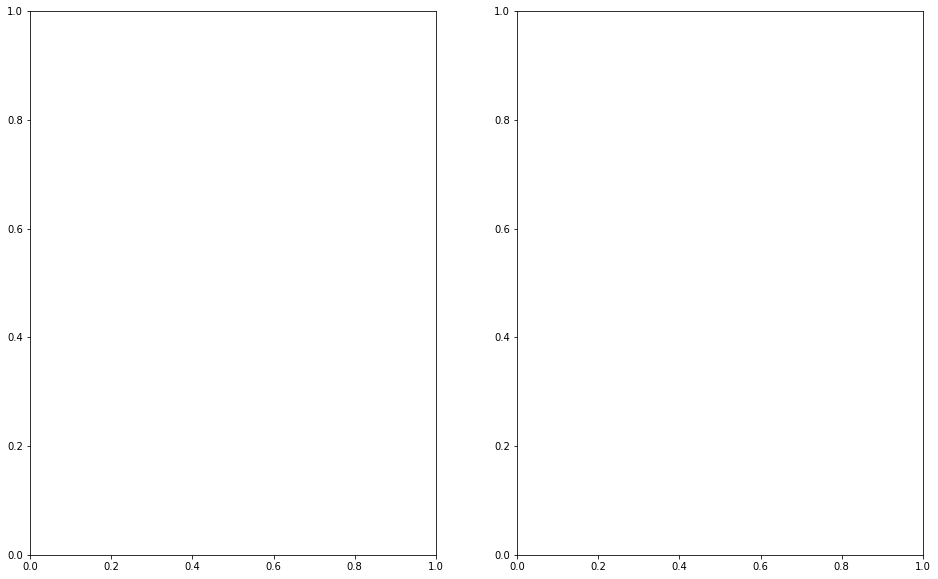

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
ax[0].hist(df_b['weight_inc'],weights=df_b['weight'], normed=1)
ax[0].set_title('With Sample Weight')

ax[1].hist(df_b['weight_inc'],normed=1,facecolor='green')
ax[1].set_title('Without Sample Weight')


#### Conclusion:
>- the weight gain rate without applying sample weight is 19.7%, which reflects the whole population weight gain rate. While it is only16.7% without applying sample weight
>- It shows it is important to apply sample weigh to ensure our analysis reflects the whole population

### 2.2 Inputs exploration

#### 2.2.1 Correlations between inputs 
>- Important Notes: Run session 3 first before this session

In [40]:
import random

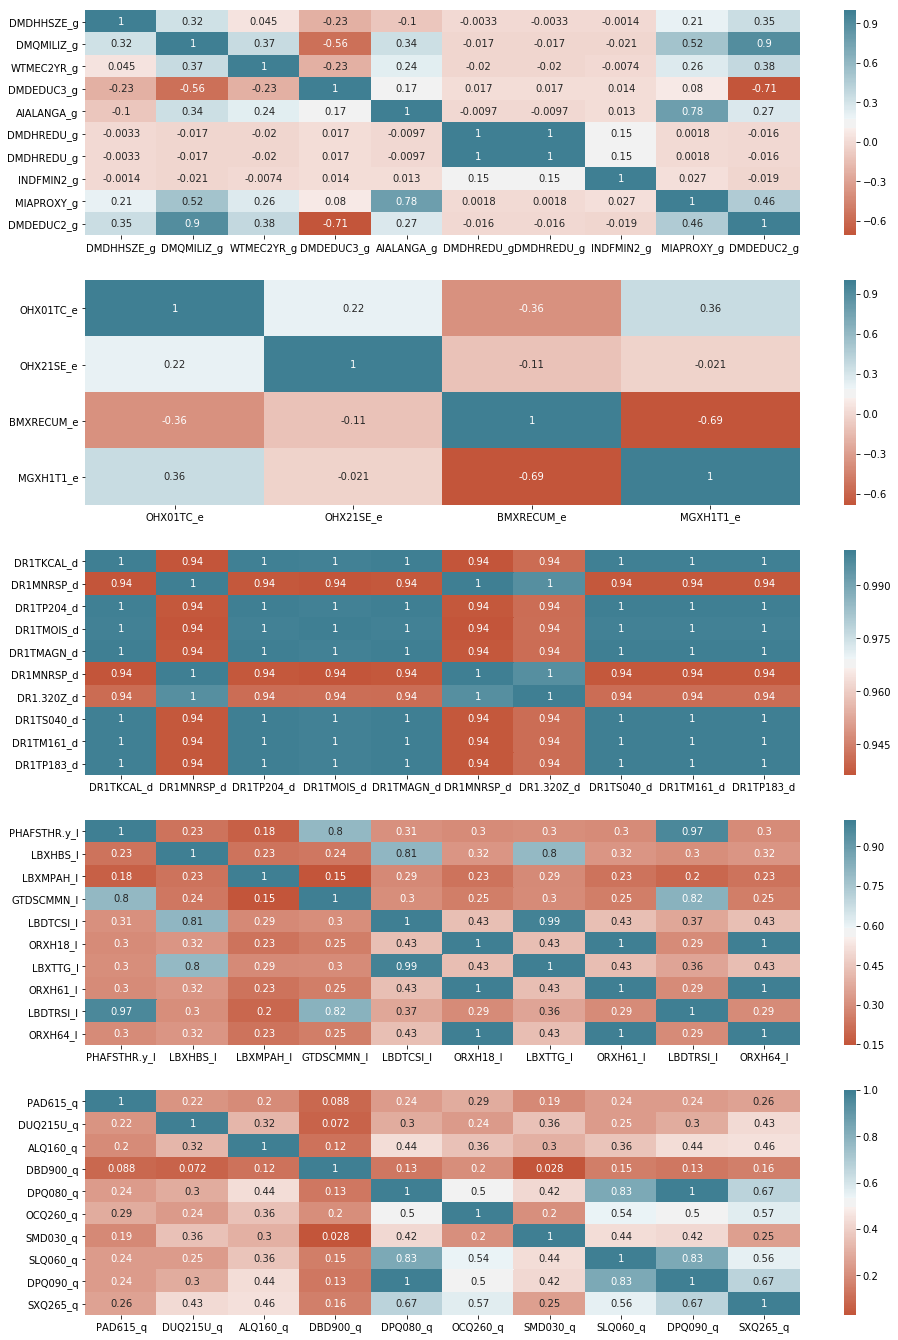

In [40]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(16,24))
suffix_list=['_g','_e','_d','_l','_q']
for i, suffix in enumerate(suffix_list):
    demo_col =  random.choices([c for c in df_b.columns if c.lower()[len(c)-2:]==suffix],k=10)
    df_demo = df_b[demo_col]
    corr_demo= df_demo.corr()
    sns.heatmap(corr_demo, 
            xticklabels=corr_demo.columns,
            yticklabels=corr_demo.columns,
               ax=ax[i],
               cmap=sns.diverging_palette(20, 220, n=200),annot=True)


In [42]:
df_b[['weight_inc','DR1TM161_d']].corr()

,weight_inc,DR1TM161_d
weight_inc,1.000000,0.055928
DR1TM161_d,0.055928,1.000000


In [ ]:
###further investigation for diet data

>- RIDEXAGM Age in months of the participant at the time of examination. Reported for persons aged 19 years or younger at the time of examination.
>- DMDFMSIZ (Total number of people in the Family) in has negative correlation with bad
>- BPXCHR: 60 sec HR (30 sec HR * 2)
>- CSQ241: Are you currently pregnant or breast feeding a baby? has positive corellation, possiblely should remove them 
>- Many variables are highly correlated, probably should remove them further 

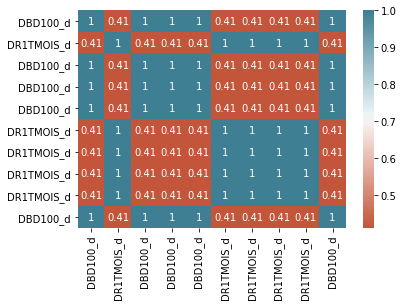

In [46]:
demo_col =  random.choices([c for c in df_s.columns if c.lower()[len(c)-2:]=='_d'],k=10)
df_demo = df_s[demo_col]
corr_demo= df_demo.corr()
sns.heatmap(corr_demo, 
        xticklabels=corr_demo.columns,
        yticklabels=corr_demo.columns,
           cmap=sns.diverging_palette(20, 220, n=200),annot=True)

## 3 Data Pre-processing

### 3.1 Categorical variables  Conversion

In [31]:
raw_col =df_a2.columns
num_cols = df_a2._get_numeric_data().columns
len(num_cols)
print("There are {} columns in total before dimensionality reduction, among them, {} are numerial \
      variables and {} are categorical variables ".format(len(raw_col),len(num_cols),(len(raw_col) - len(num_cols))))

There are 1814 columns in total before dimensionality reduction, among them, 1783 are numerial       variables and 31 are categorical variables 


In [32]:
df_a_cat = df_a2.drop(columns=num_cols[1:], axis=1).iloc[:,:]

In [33]:
# Explore exactly what the categorical variables' meaning 
df_a_cat.columns

Index(['ID', 'OHX02CTC_e', 'OHX03CTC_e', 'OHX04CTC_e', 'OHX05CTC_e',
       'OHX06CTC_e', 'OHX07CTC_e', 'OHX08CTC_e', 'OHX09CTC_e', 'OHX10CTC_e',
       'OHX11CTC_e', 'OHX12CTC_e', 'OHX13CTC_e', 'OHX14CTC_e', 'OHX15CTC_e',
       'OHX18CTC_e', 'OHX19CTC_e', 'OHX20CTC_e', 'OHX21CTC_e', 'OHX22CTC_e',
       'OHX23CTC_e', 'OHX24CTC_e', 'OHX25CTC_e', 'OHX26CTC_e', 'OHX27CTC_e',
       'OHX28CTC_e', 'OHX29CTC_e', 'OHX30CTC_e', 'OHX31CTC_e', 'CSXTSEQ_e',
       'SMDUPCA_q', 'SMD100BR_q'],
      dtype='object')

>- **Categorical variables are not predictive ones and don't seem to provide any 
predictive power to the model, so we are <font color=amber>not</font> going to use any of them**. 
>- Details are listed in the report Appendix. 
>- For this project, we are only going to focus on numerical variables
>- **Dataset to start with in next session**:df_a2


### 3.2 Dementionality Reduciton focusing on NUMERICAL variables 

In [34]:
# create a list of univraite gini
low_auc =[]
for i in num_cols:
    b = abs(roc_auc_score(y_true=df_a2['weight_inc'], y_score=df_a2[i],sample_weight=df_a2['weight'])-0.5)*2
    low_auc.append([i,b])
    
# create a list with low univaraite gini variable list < 0.05
low_auc_drop =[]
for i in num_cols:
    b = abs(roc_auc_score(y_true=df_a2['weight_inc'], y_score=df_a2[i],sample_weight=df_a2['weight'])-0.5)*2
    if b <= 0.05: 
        low_auc_drop.append([i,b])

In [35]:
low_auc1 = np.array(low_auc)
low_auc_table = pd.DataFrame({'var':low_auc1[:,0],'uni gini':low_auc1[:,1]})
result = low_auc_table.sort_values(['uni gini'],ascending=False)
result   


,var,uni gini
1662,SMQ870_q,7.545537983322248e-08
1554,PAQ759T_q,6.801348897977899e-05
1388,OSD050CA_q,5.358339495376008e-05
1429,OSQ160A_q,5.208296746994634e-06
399,DRD370QQ_d,4.976402224055043e-05
1436,OSQ220_q,3.8777476723206306e-05
1782,weight_inc,1.0
1747,WHD020_q,0.383826787043932
989,DBQ700_q,0.3557507443097738
79,BMXBMI_e,0.3524371176654144


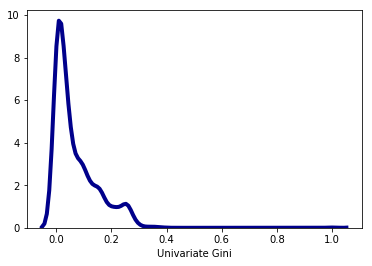

In [36]:
sns.distplot(result['uni gini'], hist=False,  norm_hist =True,
              color = 'darkblue', 
             hist_kws={'edgecolor':'black'},axlabel="Univariate Gini",
             kde_kws={'linewidth': 4})


### 3.2.2 Drop low gni

In [37]:
low_auc_drop_col = np.array(low_auc_drop)[:,0]
len(low_auc_drop_col)

1006

In [38]:
df_b = df_a2.drop(columns=low_auc_drop_col, axis=1).iloc[:,:]

In [39]:
print("Now the dataset has {} variables left after dropping low univariate gini".format(df_b.shape[1]))

Now the dataset has 808 variables left after dropping low univariate gini


In [40]:
df_b.head()

,RIDAGEYR_g,RIDEXAGM_g,DMQMILIZ_g,DMDEDUC3_g,DMDEDUC2_g,DMDMARTL_g,RIDEXPRG_g,SIAPROXY_g,MIALANG_g,MIAPROXY_g,...,WHD080R_q,WHD080S_q,WHD080T_q,WHD120_q,WHD140_q,WHQ150_q,WHQ030M_q,WHQ500_q,WHQ520_q,weight_inc
0,69,-99999.0,1.0,-99999.0,3.0,4.0,-99999.0,2.0,1.0,2.0,...,-99999.0,-99999.0,-99999.0,200.0,270.0,62.0,-99999.0,-99999.0,-99999.0,0
1,54,-99999.0,2.0,-99999.0,3.0,1.0,-99999.0,2.0,1.0,2.0,...,-99999.0,-99999.0,-99999.0,250.0,250.0,25.0,-99999.0,-99999.0,-99999.0,1
2,72,-99999.0,1.0,-99999.0,4.0,1.0,-99999.0,2.0,1.0,2.0,...,-99999.0,-99999.0,-99999.0,190.0,228.0,35.0,-99999.0,-99999.0,-99999.0,0
3,9,119.0,-99999.0,3.0,-99999.0,-99999.0,-99999.0,1.0,1.0,2.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3.0,3.0,3.0,0
4,73,-99999.0,2.0,-99999.0,5.0,1.0,-99999.0,2.0,1.0,2.0,...,-99999.0,-99999.0,-99999.0,135.0,170.0,60.0,-99999.0,-99999.0,-99999.0,0


### 3.3 Normalize data

### Skewness exploration

In [41]:
from scipy.stats import skew

In [42]:
num_cols_SKEW= list(df_b.columns)

In [43]:
# create a list of  high skewness 
highskew =[]
for i in num_cols_SKEW[0:100]:
    b =skew(df_b[i])
    highskew.append([i,b])

    


In [44]:
highskew1 = np.array(highskew)
highskew_table = pd.DataFrame({'var':highskew1[:,0],'skewness':highskew1[:,1]})
  


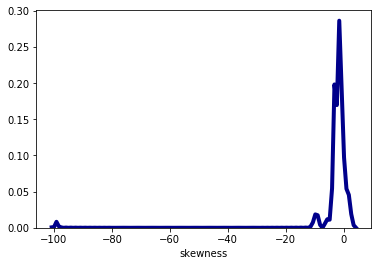

In [45]:
sns.distplot(highskew_table['skewness'], hist=False,  norm_hist =True,
              color = 'darkblue', 
             hist_kws={'edgecolor':'black'},axlabel="skewness",
             kde_kws={'linewidth': 4})

In [46]:
df_b.shape

(9813, 808)

### Normalization

In [47]:
df_b.shape
X0 = df_b.drop(columns=['weight_inc','weight','WHD020_q','WHD050_q'],axis=1).iloc[:,:]
num_norm =X0._get_numeric_data().columns
len(num_norm)
X0_n = X0[num_norm]

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)
features_norm_transform= X0_n
features_norm_transform[num_norm] = scaler.fit_transform(features_norm_transform[num_norm])
features_norm_transform.head()


df_c= features_norm_transform

In [48]:
suffix_list=['_g','_e','_d','_l','_q']

for i, suffix in enumerate(suffix_list):
    demo_col =  len(df_c[[c for c in df_c.columns if c.lower()[len(c)-2:]==suffix]].columns)
    print(i,suffix,demo_col)

0 _g 22
1 _e 107
2 _d 44
3 _l 246
4 _q 354


### 3.4 Remove Highly correlated variables
>- This is the treatment specially for Logistic Regression it requires variables to be independent from each other; while this is not a hard rule for tree based approach 
>- Note: This session will produce df_lr which will be only used for logistic regression 
>- Hence, there will be two kinds of benchmark of logistic regression being built:
    -- 1).LR will be used use **df_b** 
    -- 2).LR will be built using **df_c** (de-correlated)

In [49]:
from removecorr import remove_corr

0.005557060241699219


In [50]:
df_s0 =pd.merge(df_c, df_b[['weight_inc']],left_index=True ,right_index=True)
df_s0.head()

,RIDAGEYR_g,RIDEXAGM_g,DMQMILIZ_g,DMDEDUC3_g,DMDEDUC2_g,DMDMARTL_g,RIDEXPRG_g,SIAPROXY_g,MIALANG_g,MIAPROXY_g,...,WHD080R_q,WHD080S_q,WHD080T_q,WHD120_q,WHD140_q,WHQ150_q,WHQ030M_q,WHQ500_q,WHQ520_q,weight_inc
0,0.8625,0.000000,0.99994,0.000000,0.99994,0.999051,0.0,1.00000,0.99999,1.0,...,0.0,0.0,0.0,0.910917,0.911553,0.500310,0.00000,0.00000,0.00000,0
1,0.6750,0.000000,0.99995,0.000000,0.99994,0.999021,0.0,1.00000,0.99999,1.0,...,0.0,0.0,0.0,0.911371,0.911371,0.500125,0.00000,0.00000,0.00000,1
2,0.9000,0.000000,0.99994,0.000000,0.99995,0.999021,0.0,1.00000,0.99999,1.0,...,0.0,0.0,0.0,0.910826,0.911171,0.500175,0.00000,0.00000,0.00000,0
3,0.1125,0.998803,0.00000,0.999041,0.00000,0.000000,0.0,0.99999,0.99999,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.99994,0.99994,0.99994,0
4,0.9125,0.000000,0.99995,0.000000,0.99996,0.999021,0.0,1.00000,0.99999,1.0,...,0.0,0.0,0.0,0.910326,0.910644,0.500300,0.00000,0.00000,0.00000,0


In [51]:
df_s=remove_corr(dataframe=df_s0, badflag='weight_inc', threshold=0.5)

In [52]:
df_s.shape

(9813, 61)

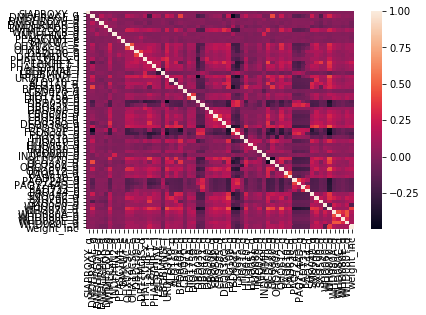

In [53]:
corr = df_s.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

>- Note: **df_s** is only used for logistic regression

> key output data with only numerical (after demention reduction with low gini): **df_b**

> Data set after normalized **df_c**

## 4   Split Dataset

### 4.1 Logistic Regression with full list

In [54]:
# isnitial trial 
X1 = df_c
Y = df_b['weight_inc']
W = df_b['weight']

In [55]:
# Import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
## spli into train and test
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X1, 
                                                    Y,W ,
                                                    test_size = 0.2, 
                                                    random_state = 0)



In [56]:
#split into train and validation 
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_train, 
                                                    y_train, w_train,
                                                    test_size = 0.25, 
                                                    random_state =123456,
                                                  )

In [57]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape))
print("Testing set has {} samples.".format(X_test.shape))
print("Training set has {} samples.".format(X_val.shape))


Training set has (5887, 773) samples.
Testing set has (1963, 773) samples.
Training set has (1963, 773) samples.


In [58]:
print("Training set has {} samples.".format(y_train.shape))
print("Testing set has {} samples.".format(y_test.shape))
print("Training set has {} samples.".format(y_val.shape))

Training set has (5887,) samples.
Testing set has (1963,) samples.
Training set has (1963,) samples.


### 4.2 Logistic regression dataset with low correlation

In [66]:
X1_lrs = df_s.drop(columns=['weight_inc'],axis=1).iloc[:,:]
X_train_lrs, X_test_lrs, y_train_lrs, y_test_lrs, w_train_lrs, w_test_lrs = train_test_split(X1_lrs, 
                                                    Y,W ,
                                                    test_size = 0.2, 
                                                    random_state = 0)
X_train_lrs, X_val_lrs, y_train_lrs, y_val_lrs, w_train_lrs, w_val_lrs = train_test_split(X_train_lrs, 
                                                    y_train_lrs, w_train_lrs,
                                                    test_size = 0.25, 
                                                    random_state =123456,
                                                  )

### 5  Build Logistic Regression
>- Apply statmodels 
>- Apply auto-groupping

### 5.1 Build LR with all variables 

In [60]:
from sklearn.linear_model import LogisticRegression 
import time 

In [61]:
lr = LogisticRegression(penalty='l2',C=2,random_state=123456)
tick = time.clock()
lr1 = lr.fit(X_train,y_train, sample_weight =w_train )
tock =time.clock()
print("Total running time for logistic regression is {}".format(tock-tick))

Total running time for logistic regression is 103.15638


In [53]:
lr1.coef_

array([[-4.77043564e-01,  3.25643524e-01, -6.59742824e-01,
        -2.24805458e-01, -1.93513188e-01,  5.57961418e-01,
         7.67931771e-02, -2.95356401e+00, -4.01480172e-01,
        -3.59312807e-01, -1.84626971e-01,  1.33073451e+01,
        -1.55071317e-01,  3.66061613e-02,  3.50946671e-01,
        -2.13481023e-01,  5.07214512e-01,  2.07221224e-01,
        -2.48549651e-01, -1.14009182e-01, -6.33557794e-01,
         4.84123459e+00,  9.37546638e+00, -3.10680839e+00,
        -4.07432565e-01, -2.07536949e+00, -1.00763563e+01,
         9.33194591e-01,  1.55269131e+00,  1.04307647e+01,
        -1.03688827e+01, -4.07315646e-01,  1.30704250e+01,
        -1.24287792e+01, -1.31628820e-01,  1.23493742e+01,
        -1.13118804e+01, -5.69506496e-01,  9.36815963e-01,
        -3.30911927e+00,  2.06903931e+00, -3.23815999e+00,
         7.40826642e-01, -2.77372264e-01,  2.42047813e-01,
         6.11796671e-02,  3.17810617e-02, -1.14640008e-01,
         2.79024051e-01, -2.09872330e-02, -3.48689091e-0

In [54]:
lr1.intercept_

array([-3.38611244])

In [55]:
#zz_test = pd.DataFrame({'ture':y_train, 'predict':y_train_pred})


In [56]:
print("Benchmark Logistic Regression a (with all inputs) Training result is {}".format(roc_auc_score(y_true = y_train, y_score=lr1.predict_proba(X_train)[:,1],sample_weight=w_train)))
print("Benchmark Logistic Regression a (with all inputs)  Validation result is {}".format(roc_auc_score(y_true = y_val, y_score=lr1.predict_proba(X_val)[:,1],sample_weight=w_val)))
print("Benchmark Logistic Regression a (with all inputs)  Test result is {}".format(roc_auc_score(y_true = y_test, y_score=lr1.predict_proba(X_test)[:,1],sample_weight=w_test)))

Benchmark Logistic Regression a (with all inputs) Training result is 0.8794093537360228
Benchmark Logistic Regression a (with all inputs)  Validation result is 0.8160757633636433
Benchmark Logistic Regression a (with all inputs)  Test result is 0.8017904005788283


In [69]:
## Performance macro
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, auc, confusion_matrix
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

def performance(model,cut_off, model_name):

#1) Gini as we care it the most
# conoutinoue pro
    y_train_pred_prob = model.predict_proba(X_train)[:,1]
    y_val_pred_prob = model.predict_proba(X_val)[:,1]
    y_test_pred_prob =  model.predict_proba(X_test)[:,1]
# binary for predictive accuracy
    y_train_pred_binary = ((model.predict_proba(X_train)[:,1]>= cut_off).astype(bool))*1
    y_val_pred_binary = ((model.predict_proba(X_val)[:,1]>= cut_off).astype(bool))*1
    y_test_pred_binary  = ((model.predict_proba(X_test)[:,1]>= cut_off).astype(bool))*1


    print ("AUC is", round((roc_auc_score(y_train,y_train_pred_prob,sample_weight=w_train))*100,2), "for Train Data")
    print ("AUC is", round((roc_auc_score(y_val,y_val_pred_prob,sample_weight=w_val))*100,2), "for Validation Data")
    print ("AUC is", round((roc_auc_score(y_test,y_test_pred_prob,sample_weight=w_test))*100,2), "for Test Data" )




#2). F1 score  - more informative than Predictive accuracy 
    train_tg, train_fb, train_fg, train_tb = confusion_matrix(y_train,y_train_pred_binary,sample_weight=w_train).ravel()
    val_tg, val_fb, val_fg, val_tb = confusion_matrix(y_val,y_val_pred_binary,sample_weight=w_val).ravel()
    test_tg, test_fb, test_fg, test_tb = confusion_matrix(y_test,y_test_pred_binary,sample_weight=w_test).ravel()
    
    print("F1 Score is ",round(f1_score(y_train,y_train_pred_binary,sample_weight=w_train),2), "for Train Data")
    print("F1 Score is ",round(f1_score(y_val,y_val_pred_binary,sample_weight=w_val),2), "for Validation Data")
    print("F1 Score is", round(f1_score(y_test,y_test_pred_binary,sample_weight=w_test),2), "for Test Data")

# compute roc curve 
#for train
    m_train=np.array(y_train)
    score_train=np.array(y_train_pred_prob)
    fpr_train, tpr_train, thresholds_b = roc_curve(m_train,score_train)
    #roc_auc_train =  auc(fpr_train, tpr_train)
    auc_train = round((roc_auc_score(y_train,y_train_pred_prob,sample_weight=w_train))*100,2)

#for val
    m_val=np.array(y_val)
    score_val=np.array(y_val_pred_prob)
    fpr_val, tpr_val, thresholds_b = roc_curve(m_val,score_val)
    #roc_auc_train =  auc(fpr_train, tpr_train)
    auc_val = round((roc_auc_score(y_val,y_val_pred_prob,sample_weight=w_val))*100,2)
    
    
    
#for test
    m_test=np.array(y_test)
    score_test=np.array(y_test_pred_prob)
    fpr_test, tpr_test, thresholds_b = roc_curve(m_test,score_test)
    #roc_auc_test =  auc(fpr_test, tpr_test)
    auc_test = round((roc_auc_score(y_test,y_test_pred_prob,sample_weight=w_test))*100,2)


    plt.figure()

#plot roc curve

    plt.plot(fpr_train, tpr_train, color="orange",lw=2,label="(train auc =%0.2f)"% auc_train )
    plt.plot(fpr_val, tpr_val, color="purple",lw=2,label="(val auc =%0.2f)"% auc_val)
    plt.plot(fpr_test, tpr_test, color="green",lw=2,label="(test auc =%0.2f)"% auc_test )
#plot diagnoal line 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

#formating our grpah 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()


AUC is 87.93 for Train Data
AUC is 81.64 for Validation Data
AUC is 80.15 for Test Data
F1 Score is  0.58 for Train Data
F1 Score is  0.5 for Validation Data
F1 Score is 0.49 for Test Data


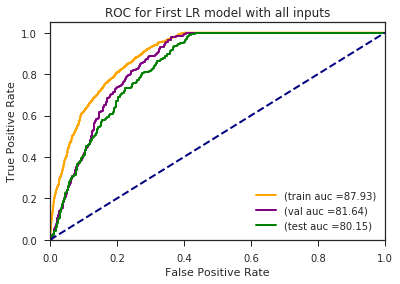

In [112]:
performance(model=lr1,cut_off=0.2, model_name="First LR model with all inputs")

### 5.2 Build LR with lowly correlated variables 

In [67]:
lr = LogisticRegression(penalty='l2',C=2,random_state=123456)
tick = time.clock()
lr1_lrs = lr.fit(X_train_lrs,y_train_lrs, sample_weight =w_train_lrs )
tock =time.clock()
print("Total running time for logistic regression is {}".format(tock-tick))

Total running time for logistic regression is 0.20489999999998076


In [70]:
## Performance macro
X_train  =X_train_lrs
X_val = X_val_lrs
X_test = X_test_lrs
def performance_ls(model,cut_off, model_name):

#1) Gini as we care it the most
# conoutinoue pro
    y_train_pred_prob = model.predict_proba(X_train)[:,1]
    y_val_pred_prob = model.predict_proba(X_val)[:,1]
    y_test_pred_prob =  model.predict_proba(X_test)[:,1]
# binary for predictive accuracy
    y_train_pred_binary = ((model.predict_proba(X_train)[:,1]>= cut_off).astype(bool))*1
    y_val_pred_binary = ((model.predict_proba(X_val)[:,1]>= cut_off).astype(bool))*1
    y_test_pred_binary  = ((model.predict_proba(X_test)[:,1]>= cut_off).astype(bool))*1


    print ("AUC is", round((roc_auc_score(y_train,y_train_pred_prob,sample_weight=w_train))*100,2), "for Train Data")
    print ("AUC is", round((roc_auc_score(y_val,y_val_pred_prob,sample_weight=w_val))*100,2), "for Validation Data")
    print ("AUC is", round((roc_auc_score(y_test,y_test_pred_prob,sample_weight=w_test))*100,2), "for Test Data" )




#2). F1 score  - more informative than Predictive accuracy 
    train_tg, train_fb, train_fg, train_tb = confusion_matrix(y_train,y_train_pred_binary,sample_weight=w_train).ravel()
    val_tg, val_fb, val_fg, val_tb = confusion_matrix(y_val,y_val_pred_binary,sample_weight=w_val).ravel()
    test_tg, test_fb, test_fg, test_tb = confusion_matrix(y_test,y_test_pred_binary,sample_weight=w_test).ravel()
    
    print("F1 Score is ",round(f1_score(y_train,y_train_pred_binary,sample_weight=w_train),2), "for Train Data")
    print("F1 Score is ",round(f1_score(y_val,y_val_pred_binary,sample_weight=w_val),2), "for Validation Data")
    print("F1 Score is", round(f1_score(y_test,y_test_pred_binary,sample_weight=w_test),2), "for Test Data")

# compute roc curve 
#for train
    m_train=np.array(y_train)
    score_train=np.array(y_train_pred_prob)
    fpr_train, tpr_train, thresholds_b = roc_curve(m_train,score_train)
    #roc_auc_train =  auc(fpr_train, tpr_train)
    auc_train = round((roc_auc_score(y_train,y_train_pred_prob,sample_weight=w_train))*100,2)

#for val
    m_val=np.array(y_val)
    score_val=np.array(y_val_pred_prob)
    fpr_val, tpr_val, thresholds_b = roc_curve(m_val,score_val)
    #roc_auc_train =  auc(fpr_train, tpr_train)
    auc_val = round((roc_auc_score(y_val,y_val_pred_prob,sample_weight=w_val))*100,2)
    
    
    
#for test
    m_test=np.array(y_test)
    score_test=np.array(y_test_pred_prob)
    fpr_test, tpr_test, thresholds_b = roc_curve(m_test,score_test)
    #roc_auc_test =  auc(fpr_test, tpr_test)
    auc_test = round((roc_auc_score(y_test,y_test_pred_prob,sample_weight=w_test))*100,2)


    plt.figure()

#plot roc curve

    plt.plot(fpr_train, tpr_train, color="orange",lw=2,label="(train auc =%0.2f)"% auc_train )
    plt.plot(fpr_val, tpr_val, color="purple",lw=2,label="(val auc =%0.2f)"% auc_val)
    plt.plot(fpr_test, tpr_test, color="green",lw=2,label="(test auc =%0.2f)"% auc_test )
#plot diagnoal line 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

#formating our grpah 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'  )
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating Curve for {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()


AUC is 83.06 for Train Data
AUC is 81.53 for Validation Data
AUC is 82.02 for Test Data
F1 Score is  0.52 for Train Data
F1 Score is  0.49 for Validation Data
F1 Score is 0.5 for Test Data


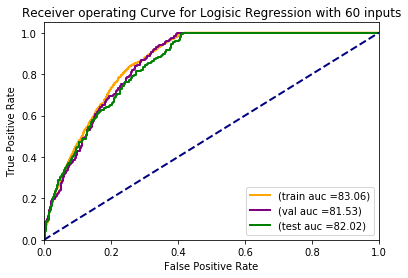

In [71]:
performance_ls(model=lr1_lrs,cut_off=0.2, model_name="Logisic Regression with 60 inputs")

In [ ]:
print("Benchmark Logistic Regression a (with low corr inputs) Training result is {}".format(roc_auc_score(y_true = y_train_lrs, y_score=lr1_lrs.predict_proba(X_train_lrs)[:,1],sample_weight=w_train_lrs)))
print("Benchmark Logistic Regression a (with low corr inputs)  Validation result is {}".format(roc_auc_score(y_true = y_val_lrs, y_score=lr1_lrs.predict_proba(X_val_lrs)[:,1],sample_weight=w_val_lrs)))
print("Benchmark Logistic Regression a (with low corr inputs)  Test result is {}".format(roc_auc_score(y_true = y_test_lrs, y_score=lr1_lrs.predict_proba(X_test_lrs)[:,1],sample_weight=w_test_lrs)))

In [ ]:
lr1_lrs.coef_

In [60]:
lr1_lrs.intercept_

array([-5.04970683])

In [73]:
import itertools
import statsmodels.formula.api as smf
model1 = smf.Logit(y_train_lrs, X_train_lrs,sample_weight=w_train_lrs)
result = model1.fit()

print(result.summary())

         Current function value: 0.306082
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             weight_inc   No. Observations:                 5887
Model:                          Logit   Df Residuals:                     5827
Method:                           MLE   Df Model:                           59
Date:                Tue, 17 Sep 2019   Pseudo R-squ.:                  0.3342
Time:                        16:51:53   Log-Likelihood:                -1801.9
converged:                      False   LL-Null:                       -2706.2
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
SIAPROXY_g     -12.7149     59.979     -0.212      0.832    -130.271     104.841
DMDHRAGE_g      -0.4541      0.229     -1.986      0.047   

In [91]:
#there are only 10 variables that are statistically significant
regression_final = ['DMDHRAGE_g',
'DMDHSEDU_g',
'DIQ175A_q',
'DBQ421_q',
'HUQ010_q',
'HUD080_q',
'OHQ780A_q',
'SXQ590_q',
'WHD080A_q',
'WHD080T_q',
#plus the weight 

]

In [92]:
X_train_lrs2 = X_train_lrs[regression_final]
X_val_lrs2 = X_val_lrs[regression_final]
X_test_lrs2= X_test_lrs[regression_final]

In [93]:
lr = LogisticRegression(penalty='l2',C=2,random_state=123456)
import time
tick = time.clock()
lr1_lrs2 = lr.fit(X_train_lrs2,y_train_lrs, sample_weight =w_train_lrs )
tock =time.clock()
print("Total running time for logistic regression is {}".format(tock-tick))

Total running time for logistic regression is 0.020000000000038654


In [161]:
print("Benchmark Logistic Regression a (with all inputs) Training result is {}".format(roc_auc_score(y_true = y_train, y_score=lr1_lrs2.predict_proba(X_train_lrs2)[:,1],sample_weight=w_train)))
print("Benchmark Logistic Regression a (with all inputs)  Validation result is {}".format(roc_auc_score(y_true = y_val, y_score=lr1_lrs2.predict_proba(X_val_lrs2)[:,1],sample_weight=w_val)))
print("Benchmark Logistic Regression a (with all inputs)  Test result is {}".format(roc_auc_score(y_true = y_test, y_score=lr1_lrs2.predict_proba(X_test_lrs2)[:,1],sample_weight=w_test)))

Benchmark Logistic Regression a (with all inputs) Training result is 0.6929291191277883
Benchmark Logistic Regression a (with all inputs)  Validation result is 0.6401123493370786
Benchmark Logistic Regression a (with all inputs)  Test result is 0.682379458675636


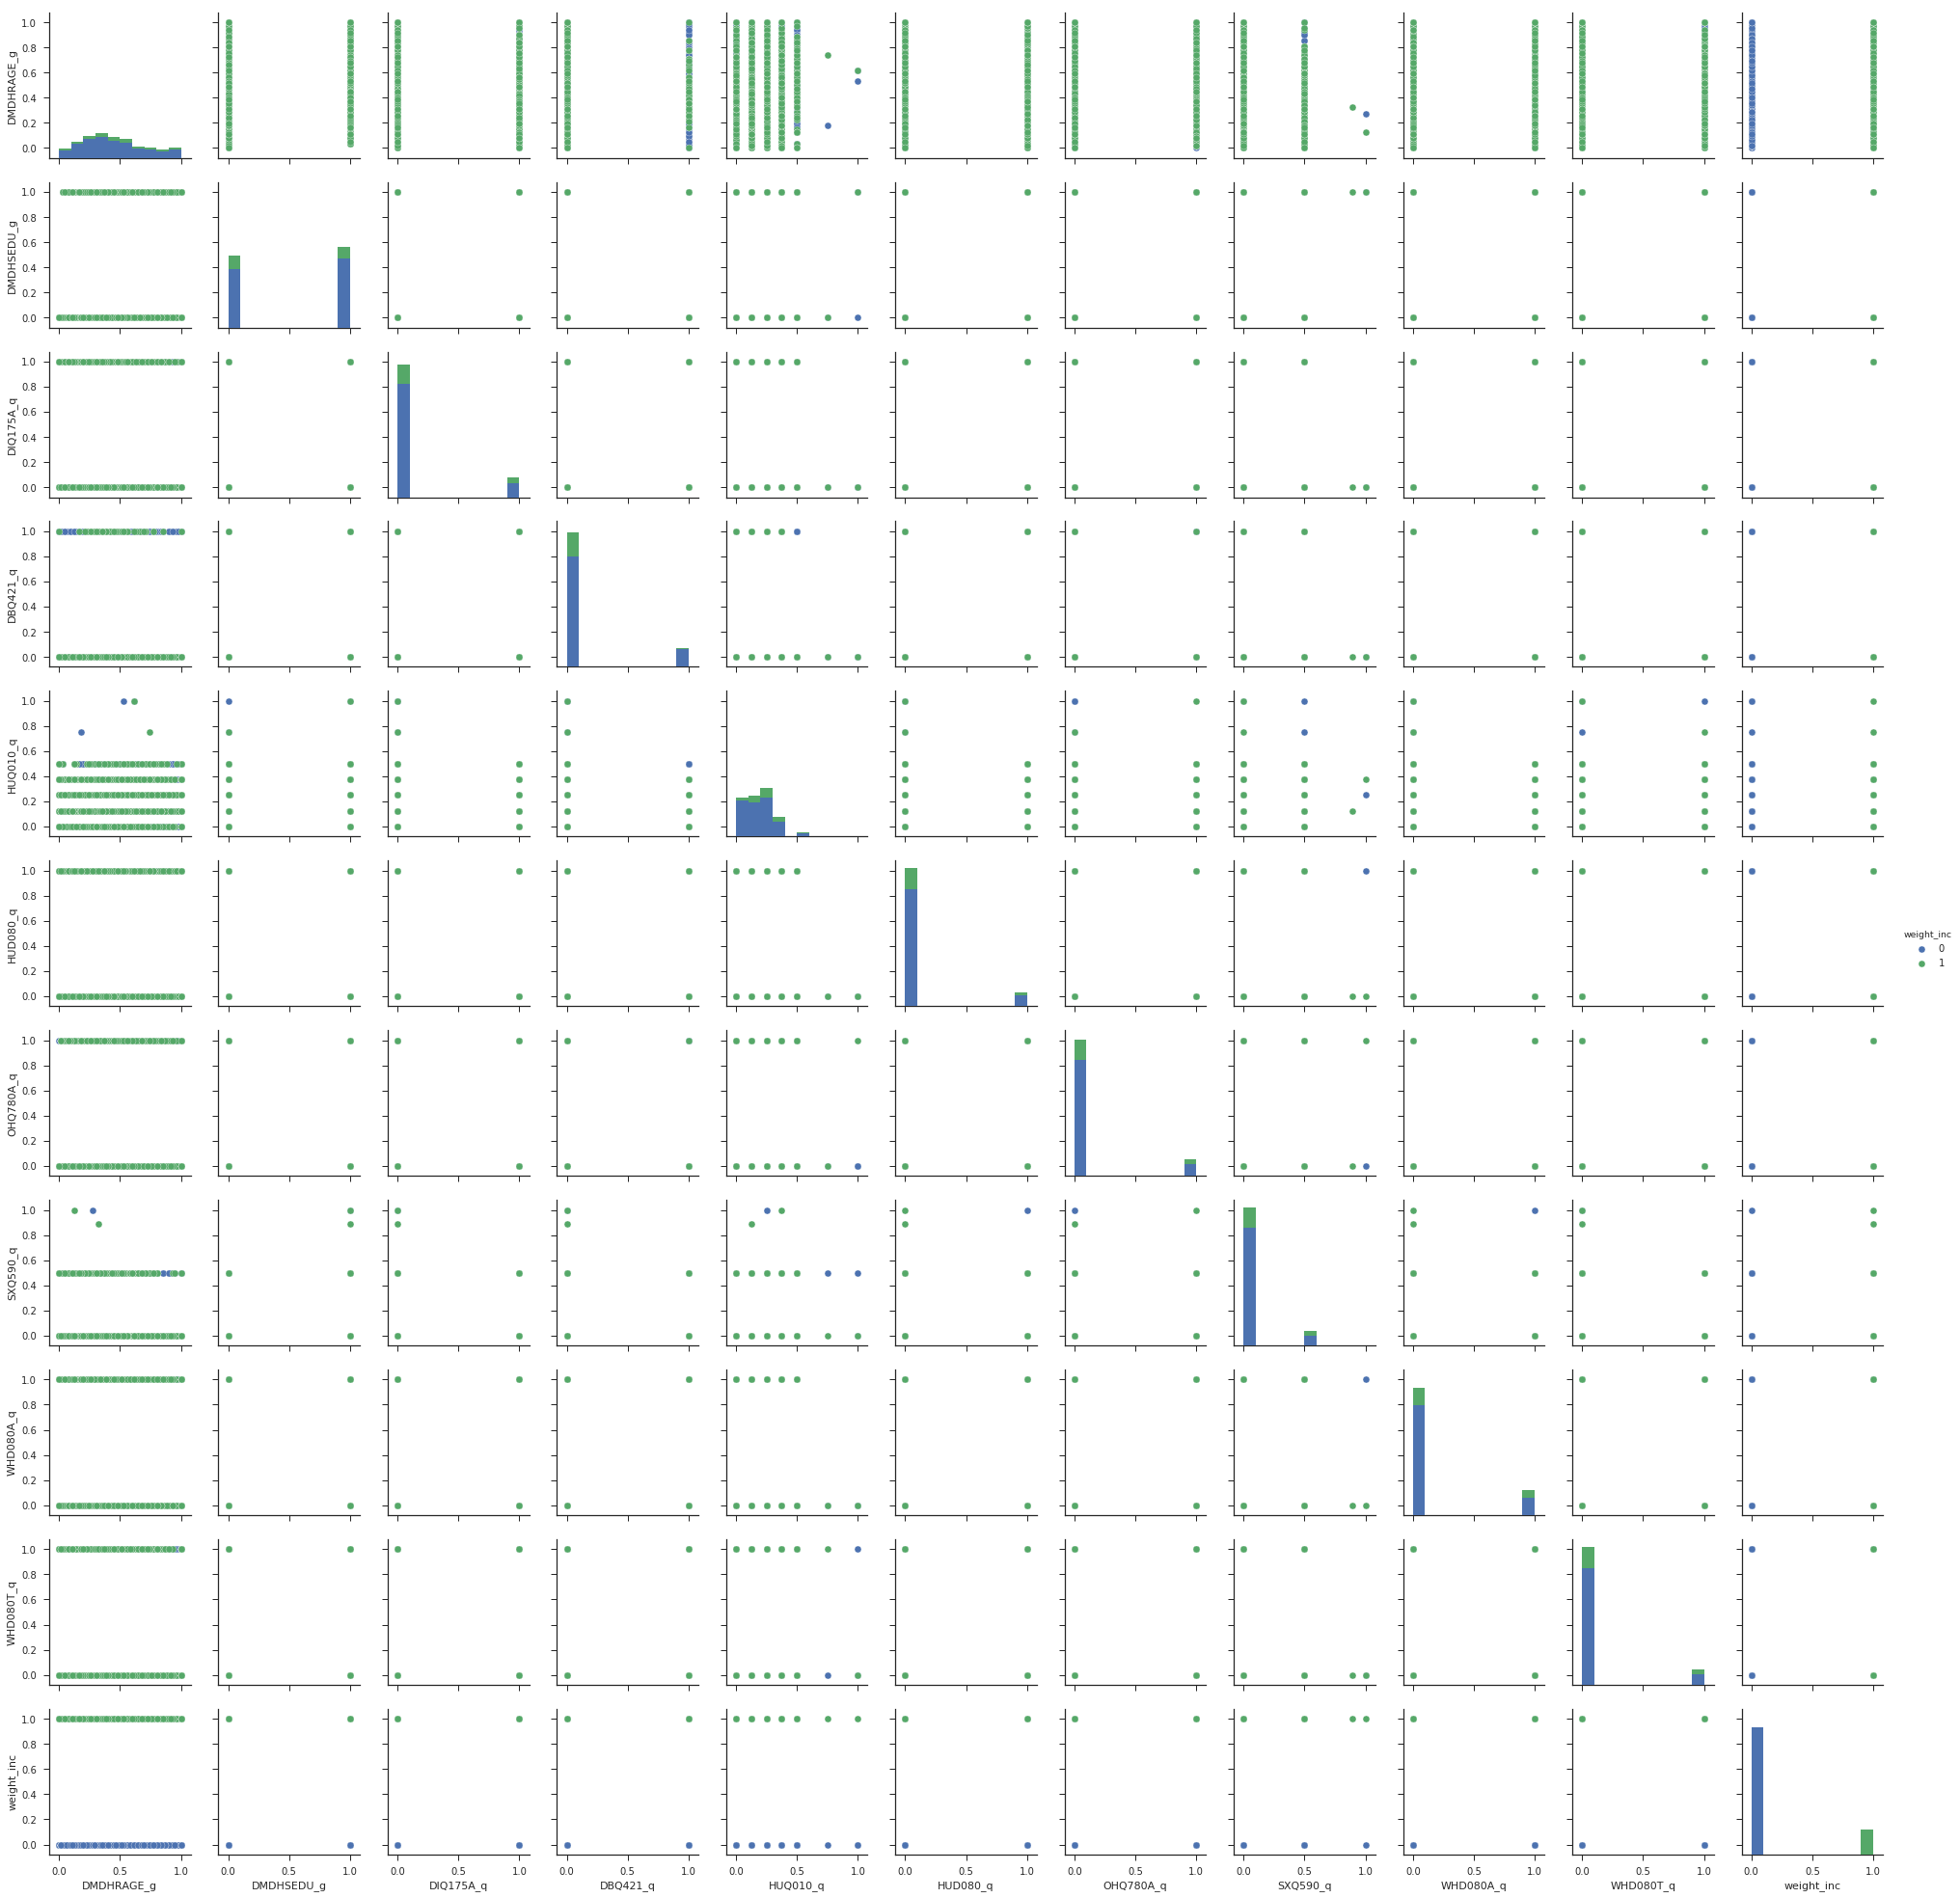

In [46]:
import seaborn as sns; 
sns.set(style="ticks", color_codes=True)
df_pairplot = df_s[regression_final]
g = sns.pairplot(df_pairplot,hue="weight_inc")
g

AUC is 69.29 for Train Data
AUC is 64.01 for Validation Data
AUC is 68.24 for Test Data
F1 Score is  0.42 for Train Data
F1 Score is  0.34 for Validation Data
F1 Score is 0.41 for Test Data


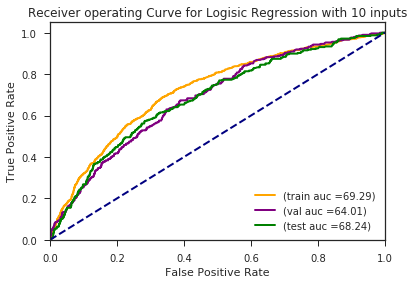

In [103]:
X_train  =X_train_lrs2
X_val = X_val_lrs2
X_test = X_test_lrs2
performance_ls(model=lr1_lrs2,cut_off=0.2, model_name="Logisic Regression with 10 inputs")

# Conclusions:
>- The Logistic Regression model with 60 features will be used as final Benchmark Model

In [83]:
!pip install emoji

     |████████████████████████████████| 51kB 1.0MB/s eta 0:00:01
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=41209 sha256=047168ad2dae576446b3516b1a9ac6c0d17681efb428d2d835ac73fbcb77bf41
  Stored in directory: /Users/peggyzhu/Library/Caches/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [84]:
import emoji

In [89]:
print(emoji.emojize('Phd is very easy!!! 😀👍'))

Phd is very easy!!! 😀👍


## Further Exploration of Model Interpretability - Elis for white box 😀🐍


$e^{i\pi} + 1 = 0$

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

<div class="alert alert-block alert-danger">
<b>Just don't:</b> In general, avoid the red boxes. These should only be
used for actions that might cause data loss or another major issue.
</div>

***

In [65]:
!pip install eli5

In [72]:
import eli5

Using TensorFlow backend.


In [77]:
all_features = list(X_train_lrs.columns)

### Global level feature importance

In [78]:
eli5.show_weights(lr1_lrs,feature_names=all_features)

### local level feature importance

In [81]:
eli5.show_prediction(lr1_lrs, X_train.iloc[[0]],feature_names=all_features,show_feature_values=True)

In [90]:
from lime.lime_tabular import LimeTabularExplainer

In [91]:

lime_explainer = LimeTabularExplainer(X_train.values, mode='classification',
                                      #training_labels = y_train,
                                      feature_names = X_train.columns.tolist(),
                                       discretize_continuous=True,
                                      random_state=123456
                                      ) 


In [97]:
i = 20

observation = X_train.iloc[[i], :].values[0]
observation

explanation = lime_explainer.explain_instance(observation,lr1_lrs.predict_proba, num_features=10)

explanation.show_in_notebook(show_table=True, show_all=False)